In [30]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import multivariate_normal as mvn

In [34]:
def build_toy_dataset(N):
  mu0 = np.zeros(D) # prior mean of the sense means
  sigma0 = np.ones(D) # prior covariance of the sense means
  a0 = np.ones(D) # prior shape for the scale of the sense covariance
  b0 = np.ones(D) # prior scale for the scale of the sense covariance   
  alpha0 = np.ones(S) # priors for the sense probabilities
  beta0 = np.ones(V) # priors over the word frequencies
    
  mus_all = []
  Sigmas_all = []
  pis_all = []

  # draw word frequencies
  pword = np.random.dirichlet(beta0)
  
  # draw the word sense distributions
  for w in range(V):
    mus = []
    Sigmas = []
    pis = np.random.dirichlet(alpha0)
    
    # draw the means for each sense
    for s in range(S):
        mus.append(np.random.multivariate_normal(mu0, np.diag(sigma0)))
        Sigmas.append(np.diag(1.0 / np.random.gamma(a0, b0)))
        
    mus_all.append(mus)
    Sigmas_all.append(Sigmas)
    pis_all.append(pis)
    
  s_all = []
  z_all = []
  c_all = []
    
  # draw the context windows for each word
  for w in range(V):
    
    # draw the sense for each context
    print('Word %i. Sense distribution = %s' % (w, str(pis_all[w])))
    s_ws = np.argmax(np.random.multinomial(1, pis_all[w], N), 1)
    z_ws = []
    
    c_ws = []
    
    for n in range(N):
        
        #print('Sense for pair n = %i' % s_ws[n])
        #print('Mean for chosen sense = %s' % str(mus_all[w][s_ws[n]]))
        #print('Cov for chosen sense = %s' % str(Sigmas_all[w][s_ws[n]]))
        
        # draw the embedding for each context
        z_ws.append(np.random.multivariate_normal(mus_all[w][s_ws[n]], Sigmas_all[w][s_ws[n]]))
    
        # construct the categorical distribution over all words
        joint = []
        for w2 in range(V):
            
            pw2 = 0
            for s in range(S):
                pw2 += pis_all[w2][s] * mvn.pdf(mus_all[w][s_ws[n]], mus_all[w2][s], Sigmas_all[w2][s])
            pw2 *= pword[w2]
            joint.append(pw2)
        
        pc_giv_z = joint / np.sum(joint)
        
        c = np.argmax(np.random.multinomial(1, pc_giv_z, C), 1)
        c_ws.append(c)
        
    s_all.append(s_ws)
    z_all.append(z_ws)
    c_all.append(c_ws)
        
  return c_all

C = 10
N = 100  # number of context windows for each word in the vocabulary
S = 2  # number of different senses per word. TODO: make this random for each word
D = 10 # dimensionality of the embeddings
V = 100 # vocabulary size

c_all = build_toy_dataset(N)

Word 0. Sense distribution = [0.12247556 0.87752444]
Word 1. Sense distribution = [0.00415894 0.99584106]
Word 2. Sense distribution = [0.89391439 0.10608561]
Word 3. Sense distribution = [0.35979186 0.64020814]
Word 4. Sense distribution = [0.2672966 0.7327034]
Word 5. Sense distribution = [0.42391225 0.57608775]
Word 6. Sense distribution = [0.36585077 0.63414923]
Word 7. Sense distribution = [0.13303995 0.86696005]
Word 8. Sense distribution = [0.62893796 0.37106204]
Word 9. Sense distribution = [0.01265489 0.98734511]
Word 10. Sense distribution = [9.99132317e-01 8.67682516e-04]
Word 11. Sense distribution = [0.1683246 0.8316754]
Word 12. Sense distribution = [0.05502526 0.94497474]
Word 13. Sense distribution = [0.45465568 0.54534432]
Word 14. Sense distribution = [0.68932879 0.31067121]
Word 15. Sense distribution = [0.95170053 0.04829947]
Word 16. Sense distribution = [0.55005569 0.44994431]
Word 17. Sense distribution = [0.91982245 0.08017755]
Word 18. Sense distribution = [0.5

In [35]:
#plt.scatter(x_train[:, 0], x_train[:, 1])
#plt.axis([-3, 3, -3, 3])
#plt.show()

In [8]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture

from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

class ContextWindow(RandomVariable, Distribution):
  def __init__(self, loc, scale, validate_args=False,
               allow_nan_stats=True, name="ContextWindow"):
    
    super(CustomRandomVariable, self).__init__(*args, **kwargs)

  def _log_prob(self, value):
    raise NotImplementedError("log_prob is not implemented")

  def _sample_n(self, n, seed=None):
    raise NotImplementedError("sample_n is not implemented")
    
#x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
#                 MultivariateNormalDiag,
#                 sample_shape=N)

S = 2
V = 100
N = 100 # sample contexts per word

pword = Dirichlet(tf.ones(V))

pi = Dirichlet(tf.ones(S), sample_shape=V) # sense distributions for each word. Needs replacing with CRP

mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=(V, S))
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=(V, S))

x = ParamMixture(pi, 
                # here we need to create our own distribution 
                sample_shape=N)
    
s = x.cat

In [11]:
from edward.models import Empirical

T = 500  # number of MCMC samples
qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [13]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()
inference.n_print = 100

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))

/Users/edwin/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


100/500 [ 20%] ██████                         ETA: 53s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.64096546 -0.6438349 ]
 [ 0.5243825   0.45005527]]
200/500 [ 40%] ████████████                   ETA: 29s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.81295204 -0.8325999 ]
 [ 0.7782518   0.72769964]]
300/500 [ 60%] ██████████████████             ETA: 16s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.8730181  -0.8929952 ]
 [ 0.85861546  0.8233759 ]]
400/500 [ 80%] ████████████████████████       ETA: 7s | Acceptance Rate: 1.000 
Inferred cluster means:
[[-0.90231866 -0.923342  ]
 [ 0.8991955   0.8716835 ]]
500/500 [100%] ██████████████████████████████ Elapsed: 35s | Acceptance Rate: 1.000

Inferred cluster means:
[[-0.9212598  -0.94001395]
 [ 0.9230946   0.89799833]]


In [14]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)


In [15]:
clusters = tf.argmax(log_liks, 1).eval()


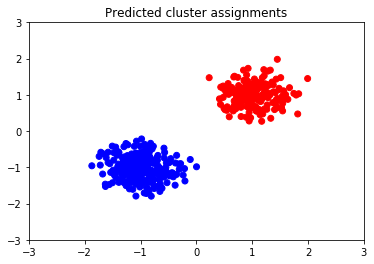

In [17]:
from matplotlib import cm 
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()
